Regression Problem on Housing Price Prediction

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pylab
import seaborn as sn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Starting with data preprocessing


In [43]:
# Load the data.
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test_df.loc[1116, "GarageType"] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median
# LotFrontage of the neighborhood.
lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

# Used to convert categorical features into ordinal numbers.
# (There's probably an easier way to do this, but it works.)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
def munge(df):
    all_df = pd.DataFrame(index = df.index)
   
    all_df["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        all_df.loc[idx, "LotFrontage"] = group.median()    

    all_df["LotArea"] = df["LotArea"]

    all_df["MasVnrArea"] = df["MasVnrArea"]
    all_df["MasVnrArea"].fillna(0, inplace=True)
   
    all_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    all_df["BsmtFinSF1"].fillna(0, inplace=True)

    all_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    all_df["BsmtFinSF2"].fillna(0, inplace=True)

    all_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    all_df["BsmtUnfSF"].fillna(0, inplace=True)

    all_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    all_df["TotalBsmtSF"].fillna(0, inplace=True)

    all_df["1stFlrSF"] = df["1stFlrSF"]
    all_df["2ndFlrSF"] = df["2ndFlrSF"]
    all_df["GrLivArea"] = df["GrLivArea"]
    
    all_df["GarageArea"] = df["GarageArea"]
    all_df["GarageArea"].fillna(0, inplace=True)

    all_df["WoodDeckSF"] = df["WoodDeckSF"]
    all_df["OpenPorchSF"] = df["OpenPorchSF"]
    all_df["EnclosedPorch"] = df["EnclosedPorch"]
    all_df["3SsnPorch"] = df["3SsnPorch"]
    all_df["ScreenPorch"] = df["ScreenPorch"]
    
    all_df["BsmtFullBath"] = df["BsmtFullBath"]
    all_df["BsmtFullBath"].fillna(0, inplace=True)

    all_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    all_df["BsmtHalfBath"].fillna(0, inplace=True)

    all_df["FullBath"] = df["FullBath"] 
    all_df["HalfBath"] = df["HalfBath"] 
    all_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    all_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    all_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    all_df["Fireplaces"] = df["Fireplaces"] 

    all_df["GarageCars"] = df["GarageCars"]
    all_df["GarageCars"].fillna(0, inplace=True)

    all_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    all_df["OverallQual"] = df["OverallQual"]
    all_df["OverallCond"] = df["OverallCond"]

    # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

    qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    all_df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    all_df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    all_df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    all_df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    all_df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    all_df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    all_df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    all_df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    all_df["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    all_df["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    all_df["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    all_df["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    all_df["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    all_df["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    all_df["YearBuilt"] = df["YearBuilt"]
    all_df["YearRemodAdd"] = df["YearRemodAdd"]

    all_df["GarageYrBlt"] = df["GarageYrBlt"]
    all_df["GarageYrBlt"].fillna(0.0, inplace=True)

    all_df["MoSold"] = df["MoSold"]
    all_df["YrSold"] = df["YrSold"]
    
    all_df["LowQualFinSF"] = df["LowQualFinSF"]
    all_df["MiscVal"] = df["MiscVal"]

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    all_df["PoolArea"] = df["PoolArea"]
    all_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, "MSSubClass")
    all_df = factorize(df, all_df, "MSZoning", "RL")
    all_df = factorize(df, all_df, "LotConfig")
    all_df = factorize(df, all_df, "Neighborhood")
    all_df = factorize(df, all_df, "Condition1")
    all_df = factorize(df, all_df, "BldgType")
    all_df = factorize(df, all_df, "HouseStyle")
    all_df = factorize(df, all_df, "RoofStyle")
    all_df = factorize(df, all_df, "Exterior1st", "Other")
    all_df = factorize(df, all_df, "Exterior2nd", "Other")
    all_df = factorize(df, all_df, "MasVnrType", "None")
    all_df = factorize(df, all_df, "Foundation")
    all_df = factorize(df, all_df, "SaleType", "Oth")
    all_df = factorize(df, all_df, "SaleCondition")

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    all_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    all_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    all_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    all_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    all_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    all_df["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

    all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1
    all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0) * 1
    all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1
    all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1
    all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1
    all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1
    all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1

    # These features actually lower the score a little.
    # all_df["HasBasement"] = df["BsmtQual"].isnull() * 1
    # all_df["HasGarage"] = df["GarageQual"].isnull() * 1
    # all_df["HasFireplace"] = df["FireplaceQu"].isnull() * 1
    # all_df["HasFence"] = df["Fence"].isnull() * 1

    # Months with the largest number of deals may be significant.
    all_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    all_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    all_df["Neighborhood_Good"].fillna(0, inplace=True)

    all_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    all_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    all_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df["TotalArea"] = all_df[area_cols].sum(axis=1)

    all_df["TotalArea1st2nd"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]

    all_df["Age"] = 2010 - all_df["YearBuilt"]
    all_df["TimeSinceSold"] = 2010 - all_df["YrSold"]

    all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df["YearsSinceRemodel"] = all_df["YrSold"] - all_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    all_df["SimplOverallQual"] = all_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplOverallCond"] = all_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplPoolQC"] = all_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    all_df["SimplGarageCond"] = all_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplGarageQual"] = all_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFunctional"] = all_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    all_df["SimplKitchenQual"] = all_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplHeatingQC"] = all_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtCond"] = all_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtQual"] = all_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterCond"] = all_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterQual"] = all_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    all_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return all_df

x_train = munge(train_df)
x_test = munge(test_df)

print(x_train.shape)
print(x_test.shape)

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = x_train["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = x_test["NeighborhoodBin"]

################################################################################

numeric_features = x_train.dtypes[x_train.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = x_train[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

x_train[skewed] = np.log1p(x_train[skewed])
x_test[skewed] = np.log1p(x_test[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train[numeric_features])

scaled = scaler.transform(x_train[numeric_features])
for i, col in enumerate(numeric_features):
    x_train[col] = scaled[:, i]

scaled = scaler.transform(x_test[numeric_features])
for i, col in enumerate(numeric_features):
    x_test[col] = scaled[:, i]

################################################################################

# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(["_" + column_name + "_" + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None, "40")
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL", "RH")
    onehot_df = onehot(onehot_df, df, "LotConfig", None, "FR3")
    onehot_df = onehot(onehot_df, df, "Neighborhood", None, "OldTown")
    onehot_df = onehot(onehot_df, df, "Condition1", None, "RRNe")
    onehot_df = onehot(onehot_df, df, "BldgType", None, "2fmCon")
    onehot_df = onehot(onehot_df, df, "HouseStyle", None, "1.5Unf")
    onehot_df = onehot(onehot_df, df, "RoofStyle", None, "Shed")
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Foundation", None, "Wood")
    onehot_df = onehot(onehot_df, df, "SaleType", "WD", "Oth")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, "LotShape", None, "IR3")
    onehot_df = onehot(onehot_df, df, "LandContour", None, "Low")
    onehot_df = onehot(onehot_df, df, "LandSlope", None, "Sev")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_df = onehot(onehot_df, df, "GarageType", "None", "CarPort")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None, "P")
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None", "Othr")

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, "Street", None, "Grvl")
    onehot_df = onehot(onehot_df, df, "Alley", "None", "Grvl")
    onehot_df = onehot(onehot_df, df, "Condition2", None, "PosA")
    onehot_df = onehot(onehot_df, df, "RoofMatl", None, "WdShake")
    onehot_df = onehot(onehot_df, df, "Heating", None, "Wall")

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, "ExterQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA", "Ex")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None", "Gd")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None", "Fin")
    onehot_df = onehot(onehot_df, df, "Fence", "None", "MnPrv")
    onehot_df = onehot(onehot_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_df

# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
x_train = x_train.join(onehot_df)

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
x_train.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
x_test = x_test.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
x_test.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
x_train.drop(drop_cols, axis=1, inplace=True)
x_test.drop(drop_cols, axis=1, inplace=True)

################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
y_train = pd.DataFrame(index = x_train.index, columns=["SalePrice"])
y_train["SalePrice"] = np.log(train_df["SalePrice"]) # y_train
print y_train.shape

print("Training set size:", x_train.shape) # x_train
print("Test set size:", x_test.shape) # x_test

(1456, 111)
(1459, 111)
(1456, 1)
('Training set size:', (1456, 403))
('Test set size:', (1459, 403))


Model fitting and predicting starts here:

 - Linear Model
 - XGBoost

In [10]:
from sklearn.linear_model import Ridge, LassoCV, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [41]:
# Grid search to find the best alpha for Ridge.
parameters = {'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 7, 9, 10, 15, 30, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75]}
ridge = Ridge()
clf = GridSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)
ridge_pred = clf.predict(x_test)
print ridge_pred.shape

score = clf.cv_results_['mean_test_score']
best_param = clf.best_params_
print(score)
print("Best Parameter is: ", best_param)

(1459, 1)
[-0.01576965 -0.01529114 -0.01457304 -0.01377746 -0.01313176 -0.01289085
 -0.01275375 -0.01266107 -0.01262448 -0.01249588 -0.01232817 -0.01226173
 -0.01225283 -0.01225245 -0.01225215 -0.01225192 -0.01225176 -0.01225167
 -0.01225164 -0.01225168 -0.01225178 -0.01225193 -0.01225215 -0.01225398]
('Best Parameter is: ', {'alpha': 66})


[0.12557727938529484, 0.12365735191255289, 0.12071884832046235, 0.11737740908068395, 0.11459391230088081, 0.11353787443153113, 0.11293249858818941, 0.11252140337960946, 0.11235869843042862, 0.11178496421196205, 0.11103227099953278, 0.11073271579732, 0.11069251996309576, 0.11069079580713337, 0.11068942030628409, 0.1106883792636872, 0.11068765923029879, 0.11068724745655936, 0.11068713184777786, 0.11068730092289865, 0.11068774377635511, 0.11068845004273865, 0.1106894098640436, 0.11069769912737649]
('Minimum RMSE for Ridge: ', 0.11068713184777786)


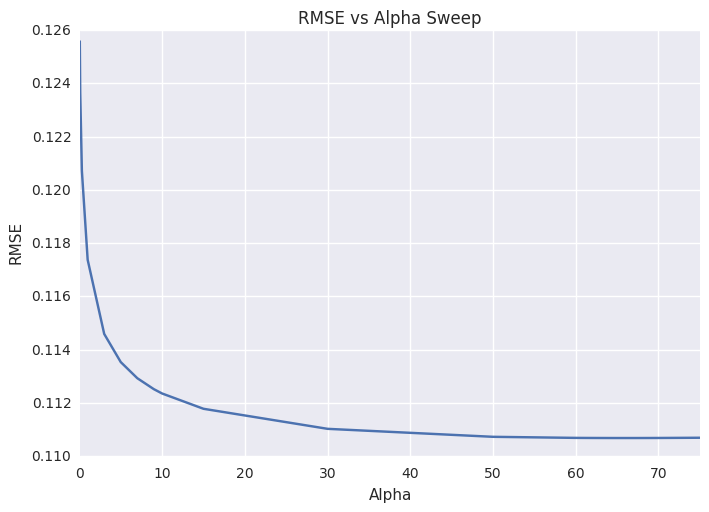

In [21]:
# Make a plot for RMSE vs Alphas to see where is the minimum
rmse = []
for i in score:
    rmse.append(np.sqrt(-i))
print(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7, 9, 10, 15, 30, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75]
cv_ridge = pd.Series(rmse, index = alphas)
_ = cv_ridge.plot(title = "RMSE vs Alpha Sweep")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Minimum RMSE for Ridge: ", cv_ridge.min())

In [22]:
# Do a quick CV to see what RMSE score we can expect from Ridge.
ridge = Ridge(alpha=66)
ridge_rmse = np.sqrt(-cross_val_score(ridge, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(ridge_rmse.mean())

0.111890411162


In [23]:
# Do CV for Lasso to find the best alpha.
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.00099, 0.0005], cv=10).fit(x_train, y_train)
lasso_score = np.sqrt(-cross_val_score(model_lasso, x_train, y_train, cv=10, scoring="neg_mean_squared_error"))
lasso_pred = model_lasso.predict(x_test)
print(lasso_score.mean(), "Chosen alpha: ", model_lasso.alpha_)

/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(0.10910025771785889, 'Chosen alpha: ', 0.00050000000000000001)


Lasso picked 138 variables and eliminated the other 265 variables


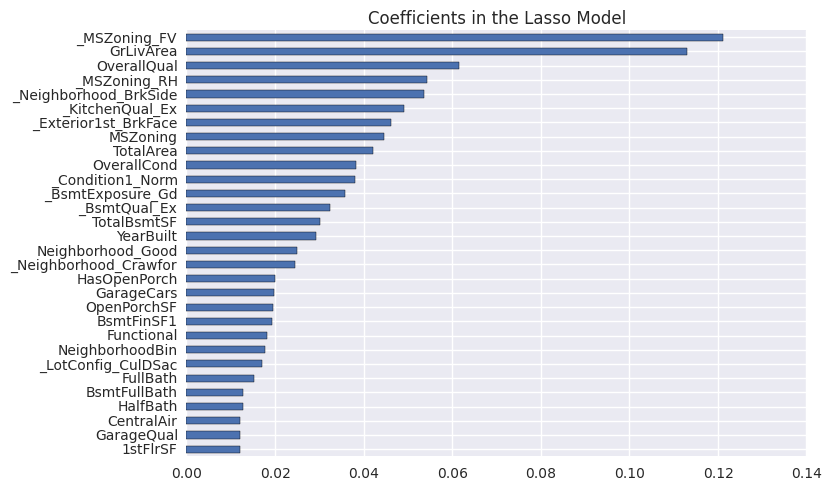

In [24]:
# Visualize the features selected by Lasso. Top 30.
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " \
      +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values(ascending=False).head(30)])
_ = imp_coef.plot(kind = "barh").invert_yaxis()
_ = plt.title("Coefficients in the Lasso Model")

Add XGBoost to the model to prepare for stacking.

In [25]:
import xgboost as xgb
from xgboost import XGBRegressor

244
     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         10.378254       0.016584        10.378265        0.003211
1          9.343424       0.016951         9.343437        0.002800
2          8.411965       0.017286         8.411978        0.002444
3          7.573819       0.017467         7.573835        0.002247
4          6.819945       0.017025         6.819654        0.002013
5          6.140635       0.016051         6.140173        0.002087
6          5.529371       0.015583         5.528866        0.001844
7          4.979365       0.015524         4.979159        0.001765
8          4.484004       0.015626         4.484169        0.001733
9          4.038308       0.015407         4.038481        0.001514
10         3.636653       0.015123         3.637351        0.001636
11         3.275589       0.014692         3.276109        0.001370
12         2.950950       0.014050         2.951424        0.001335
13         2.658302       0.013483         2

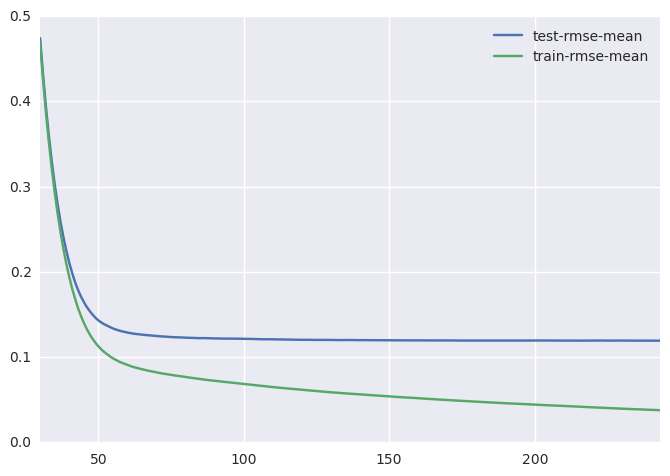

In [26]:
# Use CV to tune n_estimators needed.
xgb_cv_params = {'max_depth': 4, \
                 'subsample': 0.8, \
                 'n_estimators': 1000, \
                 'learning_rate': 0.1, \
                 'colsample_bytree': 0.5, \
                 'min_child_weight': 2, \
                 'gamma': 0, \
                 'scale_pos_weight': 1, \
                 'seed': 42, \
                }
model = xgb.cv(params=xgb_cv_params, \
               dtrain=xgb.DMatrix(x_train, y_train), \
               num_boost_round=1000, \
               nfold=5, \
               metrics='rmse', \
               early_stopping_rounds=100)

print(model.shape[0]) # This tells us n_estimators is 395
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
print(model)

In [29]:
# Grid Search with XGBoost. Tuning max_depth & min_child_weight
xgb_model = XGBRegressor()
xgb_params = {'max_depth': [3], \
              'subsample': [0.7], \
              'n_estimators': [5000], \
              'learning_rate': [0.01], \
              'colsample_bytree': [0.6], \
              'min_child_weight': [1.25], \
              'gamma': [0], \
              'scale_pos_weight': [1], \
              'reg_lambda':[0.9], \
              'seed': [42]
             }
# colsample_bytree = sqrt(288) = 17, because 288 features
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=10, verbose=1, scoring='neg_mean_squared_error')
xgb_grid.fit(x_train, y_train)
score = xgb_grid.cv_results_
print("Score: ", score)
print("mean_test_score: ", score['mean_test_score'])

mean_test_score = score['mean_test_score'].mean()
print("Average mean_test_score: ", mean_test_score)

xgb_pred = xgb_grid.predict(x_test) # This is the input training set for our stacked model.
print xgb_pred

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.7min finished


('Score: ', {'param_scale_pos_weight': masked_array(data = [1],
             mask = [False],
       fill_value = ?)
, 'rank_test_score': array([1], dtype=int32), 'param_gamma': masked_array(data = [0],
             mask = [False],
       fill_value = ?)
, 'split6_test_score': array([-0.01337843]), 'split7_train_score': array([-0.00133592]), 'split0_train_score': array([-0.00127968]), 'split2_test_score': array([-0.01071355]), 'mean_fit_time': array([ 33.66342781]), 'split3_train_score': array([-0.00125394]), 'split6_train_score': array([-0.00130442]), 'split9_test_score': array([-0.01598684]), 'std_test_score': array([ 0.00355384]), 'param_n_estimators': masked_array(data = [5000],
             mask = [False],
       fill_value = ?)
, 'params': ({'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0},), 'split8_test_score': array([-0.00823026]), '

In [30]:
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))
print'\n'
print(score['params'])
df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
print'\n'
print(df)
# df.to_csv('xgb_cv_2.csv',header=True, index_label='id')

{'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0}
(-0.012381625575110007, 0.11127275306700202)


({'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0},)


   rmse_train_score  rmse_test_score
0          0.035938         0.111273


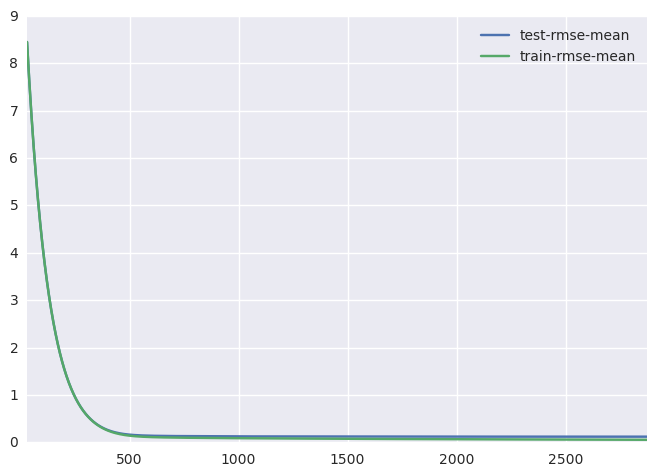

In [16]:
# After CV Check & Grid Search, we found the following parameters are the best.
# We use CV to check for overfitting.
xgb_cv_params = {'max_depth': 3, \
                 'subsample': 0.7, \
                 'n_estimators': 5000, \
                 'learning_rate': 0.01, \
                 'colsample_bytree': 0.6, \
                 'min_child_weight': 1.25, \
                 'gamma': 0, \
                 'scale_pos_weight': 1, \
                 'seed': 42, \
                }
model = xgb.cv(params=xgb_cv_params, \
               dtrain=xgb.DMatrix(x_train, y_train), \
               num_boost_round=5000, \
               nfold=5, \
               metrics='rmse', \
               early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
# print(model)

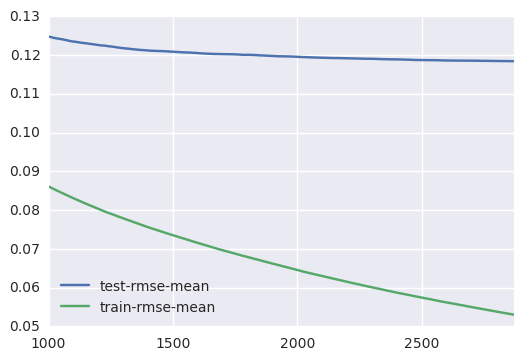

In [101]:
# Seems OK.
model.loc[1000:,["test-rmse-mean", "train-rmse-mean"]].plot()

Prepare stacking model below:
1. lasso
2. ridge
3. xgb

Wrapper:
Linear Regression

In [86]:
# We will use this function repeatedly for all 4 models to generate
# predicted weights to be trained for the stacked model.

def cv_model_output(model_func, model_name, x, y, n_folds=10):
    ''' Pass in a model with defined parameters,
    its name in string, x (features) to be trained,
    y (labels), and number of CV. '''

    folds = KFold(n_splits=n_folds)
    x_cv = np.array(x)
    y_cv = np.array(y)

    for k, (train_index, validation_index) in enumerate(folds.split(x_train)):
        x_cv_train, x_cv_val = x_cv[train_index], x_cv[validation_index]
        y_cv_train, y_cv_val = y_cv[train_index], y_cv[validation_index]

        model_func.fit(x_cv_train, y_cv_train)
        np.savetxt('{}_pred_fold_{}.txt'.format(model_name, k), np.exp(model_func.predict(x_cv_val)))
        np.savetxt('{}_test_fold_{}.txt'.format(model_name, k), y_cv_val)

In [87]:
# 1. Lasso with KFold. To be used for stacking.
ls_stack = Lasso(alpha=0.0005)
cv_model_output(ls_stack, 'ls', x_train, y_train, 10)

In [89]:
# 2. Ridge with KFold. To be used for stacking.
ridge_stack = Ridge(alpha=66)
cv_model_output(ridge_stack, 'ridge', x_train, y_train, 10)

In [90]:
# 3. Prepare XGB Kfold for stacker model.
xgb_stack = XGBRegressor(max_depth=3, \
                         subsample=0.7, \
                         n_estimators=5000, \
                         learning_rate=0.01, \
                         colsample_bytree=0.6, \
                         min_child_weight=1.25, \
                         gamma=0, \
                         scale_pos_weight=1, \
                         seed=42)
cv_model_output(xgb_stack, 'xgb', x_train, y_train, 10)

In [35]:
# 4. Prepare KNN for stacker model.
from sklearn.neighbors import KNeighborsRegressor

# Grid search to find the best n_neighbors for KNN.
parameters = {'n_neighbors':[10, 14, 22]}
neigh = KNeighborsRegressor(weights='distance')
neigh_grid = GridSearchCV(neigh, parameters, cv=10, verbose=0, n_jobs=2, scoring='neg_mean_squared_error')
neigh_grid.fit(x_train, y_train)

score = neigh_grid.cv_results_
print "\nmean_test_score: ", np.sqrt(-score['mean_test_score'])
print "\nParams: ", score['params']

best_param = neigh_grid.best_params_
print "\nBest Parameter is: ", best_param
print "\nBest Score is: ", neigh_grid.best_score_, np.sqrt(-neigh_grid.best_score_)

# Make prediction on the whole test set.
# Use this as input for wrapper (LinearRegression) prediction
knn_pred = neigh_grid.predict(x_test)


mean_test_score:  [ 0.17059677  0.17012277  0.17019586]

Params:  ({'n_neighbors': 10}, {'n_neighbors': 14}, {'n_neighbors': 22})

Best Parameter is:  {'n_neighbors': 14}

Best Score is:  -0.0289417567029 0.170122769502


In [91]:
# 4...continued, KNN with KFold. To be used for stacking.
knn_stack = KNeighborsRegressor(weights='distance', n_neighbors=14)
cv_model_output(knn_stack, 'knn', x_train, y_train, 10)

In [78]:
# 5 Random Forest Regressor Grid Search.
from sklearn.ensemble import RandomForestRegressor

# Grid search to find the best hyperparameters for RF.
parameters = {'n_estimators': [150], \
              'max_features': [0.2], \
              'max_depth': [30], \
              'min_samples_leaf': [1]}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, parameters, cv=10, verbose=1, n_jobs=2, scoring='neg_mean_squared_error')
rf_grid.fit(x_train, y_train)

score = rf_grid.cv_results_
print "\nmean_test_score: ", np.sqrt(-score['mean_test_score'])
print "\nParams: ", score['params']

best_param = rf_grid.best_params_
print "\nBest Parameter is: ", best_param
print "\nBest Score is: ", neigh_grid.best_score_, np.sqrt(-rf_grid.best_score_)

# Make prediction on the whole test set.
# Use this as input for wrapper (LinearRegression) prediction
rf_pred = rf_grid.predict(x_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   14.5s finished



mean_test_score:  [ 0.12939793]

Params:  ({'max_features': 0.2, 'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1},)

Best Parameter is:  {'max_features': 0.2, 'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1}

Best Score is:  -0.0289417567029 0.129397929893


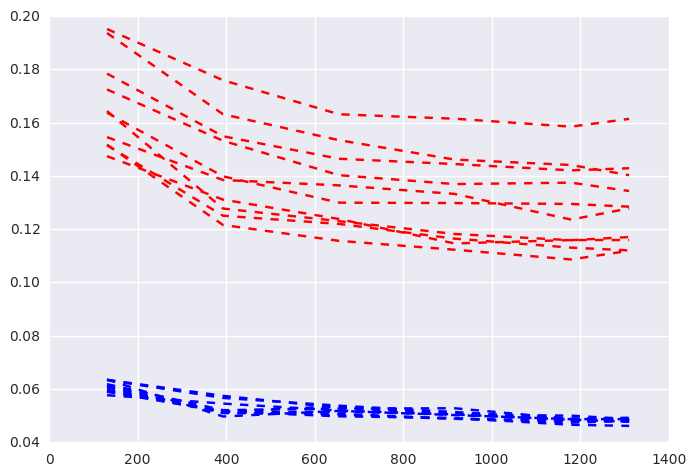

In [76]:
# Make plots for learning curve for RF to see if we are overfitting.
from sklearn.model_selection import learning_curve

rf_learning_curve = RandomForestRegressor(max_features=0.2, n_estimators=150, max_depth=30, min_samples_leaf=1)
train_sizes, train_scores, valid_scores = learning_curve(rf_learning_curve, x_train, y_train, 
                                                         train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=10,
                                                         scoring='neg_mean_squared_error', n_jobs=2)
_ = plt.plot(train_sizes, np.sqrt(-train_scores), 'b--', train_sizes, np.sqrt(-valid_scores), 'r--')

In [92]:
# 5...continued, RF with KFold. To be used for stacking.
rf_stack = rf_learning_curve
cv_model_output(rf_stack, 'rf', x_train, y_train, 10)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [93]:
# Function to load in all models.
def load_model(model_name, n_folds=10):
    ''' Input the model name to be loaded, and n_folds used.
    Returns the model that is aggregated from weights predicted from CV sets. '''

    train = []
    for i in range(n_folds):
        train.append(np.loadtxt('model_3/{}_pred_fold_{}.txt'.format(model_name, i)))

    return train

In [95]:
# Stacker model (Lasso + Ridge + XGB + KNN) using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Aggregate weights to be passed into layer 2 model
# 1. This is Lasso predicted weights from Kfold training set
train_lasso = load_model('ls', 10)
train_lasso_folds = np.hstack((train_lasso[0], train_lasso[1], train_lasso[2], train_lasso[3], \
                               train_lasso[4], train_lasso[5], train_lasso[6], \
                               train_lasso[7], train_lasso[8], train_lasso[9]))
print "\nChecking Lasso trainin set size: ", train_lasso_folds.shape

rmse_check_1 = np.sqrt(mean_squared_error(np.log(train_lasso_folds), y_train))
print "Lasso RMSE: ", rmse_check_1


# 2. This is Ridge predicted weights from Kfold training set
train_ridge = load_model('ridge', 10)
train_ridge_folds = np.hstack((train_ridge[0], train_ridge[1], train_ridge[2], train_ridge[3], \
                               train_ridge[4], train_ridge[5], train_ridge[6], \
                               train_ridge[7], train_ridge[8], train_ridge[9]))
print "\nChecking Ridge trainin set size: ", train_ridge_folds.shape

rmse_check_2 = np.sqrt(mean_squared_error(np.log(train_ridge_folds), y_train))
print "Ridge RMSE: ", rmse_check_2


# 3. This is xgb predicted weights from Kfold training set
train_xgb = load_model('xgb', 10)
train_xgb_folds = np.hstack((train_xgb[0], train_xgb[1], train_xgb[2], train_xgb[3], \
                             train_xgb[4], train_xgb[5], train_xgb[6], \
                             train_xgb[7], train_xgb[8], train_xgb[9]))
print "\nChecking XGB training set size: ", train_xgb_folds.shape

rmse_check_3 = np.sqrt(mean_squared_error(np.log(train_xgb_folds), y_train))
print "XGB RMSE: ", rmse_check_3


# 4. This is knn predicted weights from Kfold training set
train_knn = load_model('knn', 10)
train_knn_folds = np.hstack((train_knn[0], train_knn[1], train_knn[2], train_knn[3], \
                             train_knn[4], train_knn[5], train_knn[6], \
                             train_knn[7], train_knn[8], train_knn[9]))
print "\nChecking knn training set size: ", train_knn_folds.shape

rmse_check_4 = np.sqrt(mean_squared_error(np.log(train_knn_folds), y_train))
print "knn RMSE: ", rmse_check_4


# 5. This is rf predicted weights from Kfold training set
train_rf = load_model('rf', 10)
train_rf_folds = np.hstack((train_rf[0], train_rf[1], train_rf[2], train_rf[3], \
                            train_rf[4], train_rf[5], train_rf[6], \
                            train_rf[7], train_rf[8], train_rf[9]))
print "\nChecking rf training set size: ", train_rf_folds.shape

rmse_check_5 = np.sqrt(mean_squared_error(np.log(train_rf_folds), y_train))
print "rf RMSE: ", rmse_check_5


# Resize the ridge and knn prediction so they can fit into the stacker.
ridge_resized = np.resize(ridge_pred, (1459,))
knn_resized = np.resize(knn_pred, (1459,))
print '\n', xgb_pred.shape, lasso_pred.shape, ridge_resized.shape, knn_resized.shape, rf_pred.shape
# Stacking starts here.
layer_1_train_x = np.vstack((train_xgb_folds, train_lasso_folds, train_ridge_folds, train_rf_folds)).T
layer_1_test_x = np.vstack((xgb_pred, lasso_pred, ridge_resized, rf_pred)).T
lr = LinearRegression()
lr_rmse = np.sqrt(-cross_val_score(lr, np.log(layer_1_train_x), y_train, cv=5, scoring='neg_mean_squared_error'))
print "\nStacker RMSE: ", (lr_rmse.mean())

lr.fit(np.log(layer_1_train_x), y_train)
final_pred = lr.predict(layer_1_test_x)
df_final_pred = pd.DataFrame(np.exp(final_pred), index=test_df["Id"], columns=["SalePrice"])
df_final_pred.to_csv('submission7.csv', header=True, index_label='Id')
print "\n", df_final_pred.head()


Checking Lasso trainin set size:  (1456,)
Lasso RMSE:  0.109986919307

Checking Ridge trainin set size:  (1456,)
Ridge RMSE:  0.110687131848

Checking XGB training set size:  (1456,)
XGB RMSE:  0.111545713188

Checking knn training set size:  (1456,)
knn RMSE:  0.170122769502

Checking rf training set size:  (1456,)
rf RMSE:  0.129247718496

(1459,) (1459,) (1459,) (1459,) (1459,)

Stacker RMSE:  0.107329693731

          SalePrice
Id                 
1461  120535.512070
1462  158093.265837
1463  184214.017265
1464  193821.363216
1465  193464.042700
